# Mental Health Analysis ProjectA 

The purpose of this project is ...

# Data Scrapping

Reddit data

In [1]:
# scrapping data from reddit api
import requests
import pandas as pd
# import praw
import emoji
import emot
import asyncpraw
# import asyncio
from tqdm import tqdm
# loading json
import json
# load a kaomoji_to_text.json
kaomoji_to_text = json.load(open('./kaomoji_to_text.json', 'r', encoding='utf-8'))


import os
from dotenv import load_dotenv
load_dotenv()




class RedditScraper:


    def __init__(self):

        self.auth = requests.auth.HTTPBasicAuth(os.getenv('CLIENT_ID'), os.getenv('CLIENT_SECRET'))
        self.data = {'grant_type': 'password',
                     'username': os.getenv('USERNAME'),
                     'password': os.getenv('PASSWORD')}
        self.headers = {'User-Agent': 'MyAPI/0.0.1'}
        self.res = requests.post('https://www.reddit.com/api/v1/access_token',
                                auth=self.auth, data=self.data, headers=self.headers)
        
        self.headers["Authorization"] = f'bearer {self.res.json()["access_token"]}'



        self.client_id = os.getenv('CLIENT_ID')
        self.client_secret = os.getenv('CLIENT_SECRET')
        self.username = os.getenv('USERNAME')
        self.password = os.getenv('PASSWORD')





    def get_posts_byrequests(self, subreddit, limit=1000):
        url = f'https://oauth.reddit.com/r/{subreddit}/hot'
        params = {'limit': limit}
        response = requests.get(url, headers=self.headers, params=params)
        
        if response.status_code == 200:
            return response
        else:
            raise Exception(f"Error fetching posts: {response.status_code} - {response.text}")
        


    def convert_emojis_emoticons(self, text):


        # Replace kaomojis with their text equivalents
        for kaomoji, text_representation in kaomoji_to_text.items():
            # if kaomoji is in text, replace it with text_representation
            if kaomoji in text:
                text = text.replace(kaomoji, f" {text_representation} ")


        e = emot.core.emot()

        # Extract emoticons
        emoticon_results = e.emoticons(text)
        for original, meaning in zip(emoticon_results['value'], emoticon_results['mean']):
            text = text.replace(original, f" {meaning} ")

        # Extract emojis
        # emoji_results = e.emoji(text)
        # for original, meaning in zip(emoji_results['value'], emoji_results['mean']):
        #     text = text.replace(original, f" {meaning} ")
        
        # Extract emojis
        text = emoji.demojize(text)


        return text.strip().lower()
        


    async def get_posts_byprawn(self, subreddits, limit=1000, mental="mental_"):

        reddit = asyncpraw.Reddit(client_id=self.client_id,
                             client_secret=self.client_secret,
                             user_agent='windows:mentalhealth.scraper:v1.0 (by u/IceWorth5480)',
                             username=self.username,
                             password=self.password)
        
        all_posts = []
        # , 'top', 'new'
        sort_types = ['hot', 'top', 'new']


        for subreddit_name in tqdm(subreddits, desc="Subreddits Progress"):
            subreddit = await reddit.subreddit(subreddit_name)
            for sort in sort_types:
                if sort == 'hot':
                    posts = subreddit.hot(limit=limit)
                elif sort == 'top':
                    posts = subreddit.top(limit=limit)
                elif sort == 'new':
                    posts = subreddit.new(limit=limit)

                async for post in posts:
                    if post is None:
                        continue

                    # Load top-level comments (non-blocking)
                    await post.load()
                    await post.comments.replace_more(limit=0)
                    top_comments_raw = [comment.body for comment in post.comments[:5]]  # Get top 5 comments
                    top_comments = [self.convert_emojis_emoticons(c) for c in top_comments_raw]

                    all_posts.append({
                        'id': post.id,
                        'subreddit': subreddit_name,
                        'sort': sort,
                        'title': post.title,
                        'selftext': self.convert_emojis_emoticons(post.selftext),
                        'created_utc': post.created_utc,
                        'score': post.score,
                        'num_comments': post.num_comments,
                        'author': str(post.author),
                        'post_url': post.url,
                        'over_18': post.over_18,
                        'flair': post.link_flair_text,
                        'top_comments': top_comments
                    })

        await reddit.close()



        df = pd.DataFrame(all_posts)
        # Drop duplicates by post ID
        df = df.drop_duplicates(subset='id').reset_index(drop=True)
        df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
        df = df.sort_values(by='created_utc', ascending=False).reset_index(drop=True)
        # Convert list of comments to string for CSV storage
        df['top_comments'] = df['top_comments'].apply(lambda x: ' | '.join(x) if isinstance(x, list) else '')



        # check if f'./data/reddit_data/{mental}reddit_posts.csv' exists, if so merging with df and # delete dupicates by id
        if os.path.exists(f'./data/reddit_data/{mental}reddit_posts.csv'):
            existing_df = pd.read_csv(f'./data/reddit_data/{mental}reddit_posts.csv')
            df = pd.concat([existing_df, df]).drop_duplicates(subset='id').reset_index(drop=True)
       
        # save as csv 
        df.to_csv(f'./data/reddit_data/{mental}reddit_posts.csv', index=False)


In [2]:



# mental_subreddits = ['mentalhealth', 'depression', 'anxiety', 'therapy', 'selfhelp', 'bpd', 'ptsd', 'socialanxiety', 'counseling']
mental_subreddits = ['selfharm','SuicideWatch']
normal_subreddits = ['popular','all','AskReddit','interestingasfuck']
# australian_regions = ['melbourne','sydney','adelaide','perth','brisbane','canberra']


scraper  = RedditScraper()

await scraper.get_posts_byprawn(mental_subreddits, limit=1000, mental="mental_")
# await scraper.get_posts_byprawn(normal_subreddits, limit=1000, mental="normal_")




Subreddits Progress: 100%|██████████| 2/2 [1:28:48<00:00, 2664.28s/it]


In [3]:
# read the csv file 

df_mental = pd.read_csv('./data/reddit_data/mental_reddit_posts.csv')
print(df_mental.shape)

df_normal = pd.read_csv('./data/reddit_data/normal_reddit_posts.csv')
print(df_normal.shape)

(25208, 13)
(2434, 13)


Beyond Blue forums 

In [3]:
'''
TO DO

Extract following information from the reddit webpage 


Post ID: A unique identifier for each post.
Post Content: The text of the post.
Post Author: The author of the post.
Post Date: The date the post was made.
Post Category: Category or forum where the post was made.
Number of Comments: The total number of comments on the post.

From Comment 

Post ID: Link back to the original post.
Comment ID: A unique identifier for each comment.
Comment Content: Text of the comment.
Comment Author: Author of the comment.
Comment Date: Date the comment was posted. (the order of the comments is really important)
other meta data if available
'''



from bs4 import BeautifulSoup
import pandas as pd
import time
import re
from datetime import datetime, timedelta
import calendar
import os


from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, WebDriverException

from tqdm import tqdm
import emoji
import emot
# loading json
import json
# load a kaomoji_to_text.json
kaomoji_to_text = json.load(open('./kaomoji_to_text.json', 'r', encoding='utf-8'))




def parse_post_date(raw_date):

    weekdays = [day.lower() for day in list(calendar.day_name) ]
    today = datetime.now()

    raw_date = raw_date.strip().lower()  

    # Case 1: Day of the week (e.g., "Monday")
    if raw_date in weekdays:
        # Get weekday index: Monday = 0, Sunday = 6
        post_weekday_index = weekdays.index(raw_date)
        today_weekday_index = today.weekday()

        # Calculate difference in days
        delta_days = (today_weekday_index - post_weekday_index) % 7
        # Get actual date
        post_date = today - timedelta(days=delta_days)
        return post_date.strftime('%Y-%m-%d')  # Format as YYYY-MM-DD
    
    # Case 2: "a week ago", "2 weeks ago", etc.
    elif "week" in raw_date:
        match = re.search(r'(\d+)', raw_date)
        weeks = int(match.group(1)) if match else 1
        post_date = today - timedelta(weeks=weeks)
        return post_date.strftime('%Y-%m-%d')

    # Case 3: "a month ago", "2 months ago", etc.
    elif "month" in raw_date:
        match = re.search(r'(\d+)', raw_date)
        months = int(match.group(1)) if match else 1
        # Approximate a month as 30 days
        post_date = today - timedelta(days=30 * months)
        return post_date.strftime('%Y-%m-%d')
    
    # Case 4: Exact date format like "11-05-2025"
    else:
        # Try parsing date in the format like "25-09-2020"
        try:
            post_date = datetime.strptime(raw_date, '%d-%m-%Y')
            return post_date.strftime('%Y-%m-%d')
        except ValueError:
            return 'Unknown date'  # If format is unexpected




def convert_emojis_emoticons(text):


    # Replace kaomojis with their text equivalents
    for kaomoji, text_representation in kaomoji_to_text.items():
        # if kaomoji is in text, replace it with text_representation
        if kaomoji in text:
            text = text.replace(kaomoji, f" {text_representation} ")


    e = emot.core.emot()

    # Extract emoticons
    emoticon_results = e.emoticons(text)

    for original, meaning in zip(emoticon_results['value'], emoticon_results['mean']):
        text = text.replace(original, f" {meaning} ")

    # # Extract emojis
    # emoji_results = e.emoji(text)
    # for original, meaning in zip(emoji_results['value'], emoji_results['mean']):
    #     text = text.replace(original, f" {meaning} ")

    text = emoji.demojize(text)


    return text.strip().lower()




def comment_scrapping (url, comment_pages = 1,wait_time=10):

    # Setup Chrome WebDriver
    service = Service(ChromeDriverManager().install())
    comment_driver = webdriver.Chrome(service=service)
    comment_driver.set_page_load_timeout(30)

    list_comments = []

    try:
        for page in range(1, comment_pages + 1):
            try:
                comment_driver.get(url)
                WebDriverWait(comment_driver, wait_time).until(
                    EC.presence_of_element_located((By.CLASS_NAME, 'linear-message-list'))
                )
            except TimeoutException:
                print(f"[Warning] Timeout loading page {page}, skipping...")
                continue
            except WebDriverException as e:
                print(f"[Error] WebDriver issue: {e}")
                break

            soup = BeautifulSoup(comment_driver.page_source, 'html.parser')
            comments_section = soup.find('div', class_='lia-component-message-list-detail-with-inline-editors')
            comments_section = comments_section.find('div', class_='linear-message-list message-list')
            if not comments_section:
                print(f"[Warning] No comments section found on page {page}.")
                break

            every_comments = comments_section.find_all('div', recursive=False)

            for comment in every_comments:
                try:
                    main_section = comment.find('div', class_='lia-quilt-row lia-quilt-row-message-main')
                    if not main_section:
                        continue
                    comment_text = main_section.get_text(separator=' ', strip=True)
                    cleaned_comment = convert_emojis_emoticons(comment_text)
                    list_comments.append(cleaned_comment)
                except Exception as e:
                    print(f"[Warning] Error parsing a comment: {e}")
                    continue

            # Find next page link
            # next_page = soup.find('li', class_='lia-paging-page-next lia-component-next')
            next_page = soup.find('a',rel="next")

            if next_page:
                url = next_page['href']

                # Check if the next page link is valid
                if not url.startswith('http'):
                    print(f"[Warning] Invalid next page link: {url}")
                    break
            else:
                # print("No more comment pages to scrape.")
                break

    finally:
        comment_driver.quit()

    return ' ||| '.join(list_comments) if list_comments else ""



        



def beyondblue_scrapping(tag,address,pages=2):



   
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
    driver.set_page_load_timeout(30)
    url = address

    all_posts = []

    try:
        for page in tqdm(range(1, pages + 1), desc="Scraping pages"):
            try:
                driver.get(url)
                WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CLASS_NAME, 'custom-message-list'))
                )
            except TimeoutException:
                print(f"[Warning] Timeout on page {page}, skipping.")
                continue

            soup = BeautifulSoup(driver.page_source, 'html.parser')
            discussions_block = soup.find('div', class_='custom-message-list all-discussions')
            if not discussions_block:
                print(f"[Warning] No discussion list found on page {page}.")
                break

            discussions = discussions_block.find_all('article')

            for post in discussions:
                try:


                    
                    cat_side_info = post.find('aside')
                    category_info = cat_side_info.find('div', class_='custom-tile-category-content') if cat_side_info else None
                    # post_category
                    post_category = category_info.find('a').text.strip() if category_info and category_info.find('a') else ""
                    raw_date = category_info.find('time').text.strip() if category_info and category_info.find('time') else ""
                    # post_date
                    post_date = parse_post_date(raw_date)
                    
                    if pd.to_datetime(post_date, errors='coerce') < pd.to_datetime('2015-01-01'):
                        print(f"Post date {post_date} is older than 2015-01-01, skipping post.")
                        continue
                     

                    
                    post_link = post.find('h3').find_all('a')[1].get('href')
                    # post_id
                    post_id = post_link.split('/')[-1]
                    full_post_link = f"https://forums.beyondblue.org.au{post_link}"
                    # comments
                    comments = comment_scrapping(full_post_link, comment_pages=10)

                    
                    title_tag = post.find('h3').find_all('a')[1]
                    # post_title
                    post_title = convert_emojis_emoticons(title_tag.text.strip()) if title_tag else ""

                    
                    content_tag = post.find('p', class_='body-text')
                    # post_content
                    post_content = convert_emojis_emoticons(content_tag.text.strip()) if content_tag else ""

                    
                    side_info = post.find('aside')
                    author_info = side_info.find('div', class_='custom-tile-author-info') if side_info else None
                    # post_author
                    post_author = author_info.find('a').find('span').text.strip() if author_info and author_info.find('a') else ""
                    author_link = author_info.find('a').get('href') if author_info and author_info.find('a') else ""
                    # user_id
                    user_id = author_link.split('user-id/')[-1] if 'user-id/' in author_link else ""

        
                    
                    reply_info = post.find('li', class_='custom-tile-replies')
                    # num_comments
                    num_comments = reply_info.find('b').text.strip() if reply_info and reply_info.find('b') else "0"

                    # Assemble post
                    post_data = {
                        "Post ID": post_id,
                        "Post Title": post_title,
                        "Post Content": post_content,
                        "Post Author": post_author,
                        "User ID": user_id,
                        "Post Date": post_date,
                        "Post Category": post_category,
                        "Number of Comments": num_comments,
                        "Comments": comments
                    }

                    all_posts.append(post_data)

                except Exception as e:
                    print(f"[Error] Skipping post due to error: {e}")
                    continue

            # Pagination  
            next_page = soup.find('li', class_='lia-paging-page-next lia-component-next')
            if next_page and next_page.find('a'):
                url = next_page.find('a')['href']
            else:
                print("No more pages to scrape.")
                break


            # Auto-save every 10 pages
            if page % 10 == 0:
                temp_df = pd.DataFrame(all_posts).drop_duplicates(subset='Post ID').reset_index(drop=True)
                temp_df['Post Date'] = pd.to_datetime(temp_df['Post Date'], errors='coerce')
                temp_df = temp_df.sort_values(by='Post Date', ascending=False).reset_index(drop=True)

                save_dir = './data/beyondblue_data'
                os.makedirs(save_dir, exist_ok=True)
                save_path = os.path.join(save_dir, f'{tag}_beyondblue_posts.csv')

                if os.path.exists(save_path):
                    existing_df = pd.read_csv(save_path)
                    temp_df = pd.concat([existing_df, temp_df]).drop_duplicates(subset='Post ID').reset_index(drop=True)

                temp_df.to_csv(save_path, index=False)
                print(f"💾 Auto-saved data to {save_path} at page {page}")

            # if the oldest post is older than 2020-01-01, stop the scraping
            # if not temp_df.empty and temp_df['Post Date'].min() < pd.to_datetime('2020-01-01'):
            #     print(f"The oldest post is older than 2020-01-01, stopping the scraping for tag {tag}.")
            #     break


    finally:
        driver.quit()

    # Saving to CSV
    df = pd.DataFrame(all_posts).drop_duplicates(subset='Post ID').reset_index(drop=True)
    df['Post Date'] = pd.to_datetime(df['Post Date'], errors='coerce')
    df = df.sort_values(by='Post Date', ascending=False).reset_index(drop=True)

    save_dir = './data/beyondblue_data'
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f'{tag}_beyondblue_posts.csv')

    if os.path.exists(save_path):
        existing_df = pd.read_csv(save_path)
        df = pd.concat([existing_df, df]).drop_duplicates(subset='Post ID').reset_index(drop=True)

    df.to_csv(save_path, index=False)
    print(f"✅ Data saved to {save_path} with {len(df)} total posts.")




In [3]:

mental_health_urls = {
    # "Anxiety": "https://forums.beyondblue.org.au/t5/anxiety/bd-p/c1-sc2-b1?&sort=recent",
    # "Depression": "https://forums.beyondblue.org.au/t5/depression/bd-p/c1-sc2-b2?&sort=recent",
    # "PTSD": "https://forums.beyondblue.org.au/t5/ptsd-and-trauma/bd-p/c1-sc2-b3?&sort=recent",
    # "Suicide_selfharm": "https://forums.beyondblue.org.au/t5/suicidal-thoughts-and-self-harm/bd-p/c1-sc2-b4?&sort=recent",
    # "Staying_well": "https://forums.beyondblue.org.au/t5/staying-well/bd-p/c1-sc3-b1?&sort=recent",
    # "Treament": "https://forums.beyondblue.org.au/t5/treatments-health-professionals/bd-p/c1-sc3-b2?&sort=recent",
    # "Relationship_family_issues":"https://forums.beyondblue.org.au/t5/relationship-and-family-issues/bd-p/c1-sc3-b3?&sort=recent",
    # "Youth":"https://forums.beyondblue.org.au/t5/young-people/bd-p/c1-sc4-b1?&sort=recent",
    "Sex_identity":"https://forums.beyondblue.org.au/t5/sexuality-and-gender-identity/bd-p/c1-sc4-b2?&sort=recent",
    "Multiculture":"https://forums.beyondblue.org.au/t5/multicultural-experiences/bd-p/c1-sc4-b3?&sort=recent",
    "Grief_loss":"https://forums.beyondblue.org.au/t5/grief-and-loss/bd-p/c1-sc4-b4?&sort=recent"
}



for tag, address in mental_health_urls.items():
    try:
        beyondblue_scrapping(tag, address, pages = 50)
    except Exception as e:
        print(f"Error scraping {tag}: {e}")
        continue

Scraping pages:  16%|█▌        | 8/50 [12:36<1:04:51, 92.66s/it] 

Post date 2014-07-15 is older than 2015-01-01, skipping post.


Scraping pages:  20%|██        | 10/50 [15:27<59:32, 89.32s/it] 

💾 Auto-saved data to ./data/beyondblue_data\Sex_identity_beyondblue_posts.csv at page 10


Scraping pages:  24%|██▍       | 12/50 [18:07<53:20, 84.23s/it]

Post date 2013-06-09 is older than 2015-01-01, skipping post.


Scraping pages:  40%|████      | 20/50 [30:06<44:47, 89.59s/it]

💾 Auto-saved data to ./data/beyondblue_data\Sex_identity_beyondblue_posts.csv at page 20


Scraping pages:  52%|█████▏    | 26/50 [39:28<36:35, 91.46s/it]

Post date 2014-06-25 is older than 2015-01-01, skipping post.


Scraping pages:  60%|██████    | 30/50 [45:01<28:51, 86.55s/it]

💾 Auto-saved data to ./data/beyondblue_data\Sex_identity_beyondblue_posts.csv at page 30


Scraping pages:  80%|████████  | 40/50 [1:00:34<15:52, 95.21s/it]

💾 Auto-saved data to ./data/beyondblue_data\Sex_identity_beyondblue_posts.csv at page 40


Scraping pages:  90%|█████████ | 45/50 [1:09:01<08:38, 103.62s/it]

Post date 2014-04-29 is older than 2015-01-01, skipping post.


Scraping pages: 100%|██████████| 50/50 [1:16:12<00:00, 91.46s/it] 

💾 Auto-saved data to ./data/beyondblue_data\Sex_identity_beyondblue_posts.csv at page 50


✅ Data saved to ./data/beyondblue_data\Sex_identity_beyondblue_posts.csv with 992 total posts.


Scraping pages:  20%|██        | 10/50 [16:21<1:08:33, 102.84s/it]

💾 Auto-saved data to ./data/beyondblue_data\Multiculture_beyondblue_posts.csv at page 10


Scraping pages:  40%|████      | 20/50 [32:36<46:22, 92.74s/it]   

💾 Auto-saved data to ./data/beyondblue_data\Multiculture_beyondblue_posts.csv at page 20


Scraping pages:  50%|█████     | 25/50 [40:49<40:49, 97.97s/it]

No more pages to scrape.


✅ Data saved to ./data/beyondblue_data\Multiculture_beyondblue_posts.csv with 456 total posts.


Scraping pages:  20%|██        | 10/50 [14:51<57:51, 86.79s/it] 

💾 Auto-saved data to ./data/beyondblue_data\Grief_loss_beyondblue_posts.csv at page 10


Scraping pages:  40%|████      | 20/50 [29:12<43:27, 86.93s/it]

💾 Auto-saved data to ./data/beyondblue_data\Grief_loss_beyondblue_posts.csv at page 20


Scraping pages:  60%|██████    | 30/50 [44:40<31:35, 94.76s/it]

💾 Auto-saved data to ./data/beyondblue_data\Grief_loss_beyondblue_posts.csv at page 30


Scraping pages:  80%|████████  | 40/50 [59:01<14:14, 85.42s/it]

💾 Auto-saved data to ./data/beyondblue_data\Grief_loss_beyondblue_posts.csv at page 40


Scraping pages:  98%|█████████▊| 49/50 [1:11:35<01:24, 84.42s/it]

Post date 2014-12-16 is older than 2015-01-01, skipping post.


Scraping pages: 100%|██████████| 50/50 [1:12:54<00:00, 87.49s/it]

💾 Auto-saved data to ./data/beyondblue_data\Grief_loss_beyondblue_posts.csv at page 50


✅ Data saved to ./data/beyondblue_data\Grief_loss_beyondblue_posts.csv with 998 total posts.


Climate data API

In [4]:
import pandas as pd
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

url = "https://reg.bom.gov.au/climate/data/"

weather_types = ['Rainfall', 'Temp_Max', 'Temp_Min', 'Solar exposure']
australian_regions = ['NSW', 'VIC', 'QLD', 'WA', 'SA', 'TAS', 'ACT', 'NT']
australian_citys = ['Sydney', 'Melbourne', 'Brisbane', 'Perth', 'Adelaide', 'Hobart', 'Canberra', 'Darwin']

zip_url = {}

for weather_type in weather_types:
    for region, city in zip(australian_regions, australian_citys):
        service = Service(ChromeDriverManager().install())
        driver = webdriver.Chrome(service=service)

        try:
            driver.get(url)
            wait = WebDriverWait(driver, 20)

            # Select weather type
            data_about_dropdown = wait.until(EC.presence_of_element_located((By.ID, 'ncc_obs_code_group')))
            dropdown_xpath = {
                'Rainfall': "Rainfall",
                'Temp_Max': "Temperature",
                'Temp_Min': "Temperature",
                'Solar exposure': "Solar exposure"
            }
            data_about_dropdown.find_element(By.XPATH, f"//option[text()='{dropdown_xpath[weather_type]}']").click()
            time.sleep(1)

            # Select sub-option for Temperature
            if weather_type in ['Temp_Max', 'Temp_Min']:
                wait.until(EC.visibility_of_element_located((By.ID, 'elementSubSelectLine')))
                element_select = wait.until(EC.presence_of_element_located((By.ID, 'elementSubSelect')))
                option_text = 'Maximum temperature' if weather_type == 'Temp_Max' else 'Minimum temperature'
                element_select.find_element(By.XPATH, f"//option[text()='{option_text}']").click()
                time.sleep(1)

            # Input city
            location_input = wait.until(EC.presence_of_element_located((By.ID, 'p_locSearch')))
            location_input.clear()
            location_input.send_keys(city)

            # Click Find button and wait for match list
            driver.find_element(By.ID, 'text').click()
            wait.until(EC.presence_of_element_located((By.ID, 'matchList')))
            time.sleep(1)
            match_list = driver.find_element(By.ID, 'matchList')
            match_list.find_elements(By.TAG_NAME, 'option')[0].click()
            time.sleep(1)

            # Show open stations only
            open_station_checkbox = wait.until(EC.element_to_be_clickable((By.ID, 'openStation')))
            if not open_station_checkbox.is_selected():
                open_station_checkbox.click()
                time.sleep(2)  # Wait for list to refresh

            # Select first station
            nearest_stations = wait.until(EC.presence_of_element_located((By.ID, 'nearest10')))
            station_options = nearest_stations.find_elements(By.TAG_NAME, 'option')
            if len(station_options) == 0:
                print(f'!!! No stations found for {city} - {weather_type}')
                continue

            station_options[0].click()
            time.sleep(1)

            # Wait for station number to load
            wait.until(lambda d: d.find_element(By.ID, 'p_stn_num').get_attribute('value').strip() != '')

            # Get data
            get_data_button = wait.until(EC.element_to_be_clickable((By.ID, 'getData')))
            get_data_button.click()

            # Wait and switch to new tab
            wait.until(lambda d: len(d.window_handles) > 1)
            driver.switch_to.window(driver.window_handles[-1])
            time.sleep(2)

            # Wait for downloads section
            wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'downloads')))
            all_years_link = driver.find_element(By.LINK_TEXT, 'All years of data')
            href = all_years_link.get_attribute('href')

            # Save link
            zip_url_key = f'{region}_{city}_{weather_type}'
            zip_url[zip_url_key] = href
            print(f'Collected ZIP URL for {city} - {weather_type}: {href}')

            driver.close()
            driver.switch_to.window(driver.window_handles[0])

        except Exception as e:
            print(f'Error processing {city} - {weather_type}: {e}')
            print("=================================================")
        finally:
            driver.quit()
            print("=================================================")

# Save the results
print("\nAll collected ZIP URLs:")
for key, link in zip_url.items():
    print(f'{key}: {link}')

df_urls = pd.DataFrame(list(zip_url.items()), columns=['Region_City_WeatherType', 'ZIP_URL'])
df_urls.to_csv('./data/AUS_weather/zip_urls.csv', index=False)

Error processing Sydney - Rainfall: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=138.0.7204.101)
Stacktrace:
	GetHandleVerifier [0x0x891a33+62339]
	GetHandleVerifier [0x0x891a74+62404]
	(No symbol) [0x0x6d2123]
	(No symbol) [0x0x6b0fc9]
	(No symbol) [0x0x745aee]
	(No symbol) [0x0x760089]
	(No symbol) [0x0x73f1b6]
	(No symbol) [0x0x70e7a2]
	(No symbol) [0x0x70f644]
	GetHandleVerifier [0x0xb065c3+2637587]
	GetHandleVerifier [0x0xb019ca+2618138]
	GetHandleVerifier [0x0x8b84aa+220666]
	GetHandleVerifier [0x0x8a88d8+156200]
	GetHandleVerifier [0x0x8af06d+182717]
	GetHandleVerifier [0x0x899978+94920]
	GetHandleVerifier [0x0x899b02+95314]
	GetHandleVerifier [0x0x884c4a+9626]
	BaseThreadInitThunk [0x0x766d5d49+25]
	RtlInitializeExceptionChain [0x0x775ad1ab+107]
	RtlGetAppContainerNamedObjectPath [0x0x775ad131+561]



KeyboardInterrupt: 

download weather data from BOM by zip file

In [5]:


import os
import requests
import zipfile
import pandas as pd

# Load ZIP URLs from CSV
df_urls = pd.read_csv('./data/AUS_weather/zip_urls.csv')
dict_zip_urls = dict(zip(df_urls['Region_City_WeatherType'], df_urls['ZIP_URL']))

# Group keys by Region_City prefix (e.g., NSW_Sydney)
city_groups = {}
for key in dict_zip_urls.keys():
    city = '_'.join(key.split('_')[:2])
    if city not in city_groups:
        city_groups[city] = []
    city_groups[city].append(key)

# Create output folder
os.makedirs('./data/AUS_weather/merged_per_city', exist_ok=True)

# Iterate over each city
for city, keys in city_groups.items():
    print(f"\n Processing: {city}")

    dfs = []
    for key in keys:
        try:
            url = dict_zip_urls[key]
            print(f"  ⬇ Downloading: {key}")
            response = requests.get(url)
            print(f"    Content-Type: {response.headers.get('Content-Type')}")

            # Save the ZIP file to disk
            zip_filename = f"{key}.zip"
            with open(zip_filename, 'wb') as temp_file:
                temp_file.write(response.content)
            print(f"    Saved {zip_filename} for inspection.")

            if response.status_code != 200:
                print(f"    !!! Failed to download {key}")
                continue

            # Extract the CSV file from the ZIP
            with zipfile.ZipFile(zip_filename, 'r') as z:
                csv_name = z.namelist()[0]
                z.extract(csv_name, './data/AUS_weather/merged_per_city')
                print(f"    Extracted {csv_name} to ./data/AUS_weather/merged_per_city")

                # Read the CSV into a DataFrame
                csv_path = os.path.join('./data/AUS_weather/merged_per_city', csv_name)
                df = pd.read_csv(csv_path)

            # Remove the ZIP file
            os.remove(zip_filename)
            print(f"    Deleted ZIP file: {zip_filename}")

            # Optionally, remove the extracted CSV after processing
            os.remove(csv_path)

            # ...rest of your processing...
            df.drop(columns=['Product code', 'Bureau of Meteorology station number'], errors='ignore', inplace=True)
            base_cols = ['Year', 'Month', 'Day']
            weather_cols = [col for col in df.columns if col not in base_cols]
            df = df[base_cols + weather_cols]
            weather_type = '_'.join(key.split('_')[2:])
            df.rename(columns={col: f"{weather_type}_{col}" for col in weather_cols}, inplace=True)
            dfs.append(df)

        except Exception as e:
            print(f"    !!! Error processing {key}: {e}")

    # Merge all weather types on Year-Month-Day
    if dfs:
        merged_df = dfs[0]
        for other_df in dfs[1:]:
            merged_df = pd.merge(merged_df, other_df, on=['Year', 'Month', 'Day'], how='outer')

        # Add 'location' column
        merged_df['location'] = city

        # Save merged file
        merged_df.to_csv(f'./data/AUS_weather/merged_per_city/{city}_merged.csv', index=False)
        print(f" Saved: {city}_merged.csv")
        print("==================================================")
    else:
        print(f"!!! Skipping {city}, no valid data.")
        print("==================================================")

        
        



 Processing: NSW_Sydney
  ⬇ Downloading: NSW_Sydney_Rainfall
    Content-Type: application/zip
    Saved NSW_Sydney_Rainfall.zip for inspection.
    !!! Error processing NSW_Sydney_Rainfall: File is not a zip file
  ⬇ Downloading: NSW_Sydney_Temp_Max
    Content-Type: application/zip
    Saved NSW_Sydney_Temp_Max.zip for inspection.
    !!! Error processing NSW_Sydney_Temp_Max: File is not a zip file
  ⬇ Downloading: NSW_Sydney_Temp_Min
    Content-Type: application/zip
    Saved NSW_Sydney_Temp_Min.zip for inspection.
    !!! Error processing NSW_Sydney_Temp_Min: File is not a zip file
  ⬇ Downloading: NSW_Sydney_Solar exposure
    Content-Type: application/zip
    Saved NSW_Sydney_Solar exposure.zip for inspection.
    !!! Error processing NSW_Sydney_Solar exposure: File is not a zip file
!!! Skipping NSW_Sydney, no valid data.

 Processing: VIC_Melbourne
  ⬇ Downloading: VIC_Melbourne_Rainfall
    Content-Type: application/zip
    Saved VIC_Melbourne_Rainfall.zip for inspection.
  

KeyboardInterrupt: 

Concate all weather data from different state

In [ ]:

import pandas as pd
import os

current_dir = os.getcwd()
target_path = os.path.join(current_dir, 'data', 'AUS_weather')

# concatenate all csv files into one dataframe except one csv file called Australia_disaster-mapper-data-21-03-2023.csv
all_files = [f for f in os.listdir(target_path) if f.endswith('.csv') and f != 'Australia_disaster-mapper-data-21-03-2023.csv']
dfs = []
for file in all_files:
    file_path = os.path.join(target_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all dataframes
merged_df = pd.concat(dfs, ignore_index=True)
# Save the merged dataframe to a new CSV file
merged_df.to_csv(os.path.join(target_path, 'AUS_bigcity_weather_data.csv'), index=False)




In [ ]:

from datetime import timedelta
import pandas as pd
import os
current_dir = os.getcwd()
target_path = os.path.join(current_dir, 'data', 'AUS_weather')





# australian_regions = ['NSW', 'VIC', 'QLD', 'WA', 'SA', 'TAS', 'ACT', 'NT']
# australian_citys = ['Sydney', 'Melbourne', 'Brisbane', 'Perth', 'Adelaide', 'Hobart', 'Canberra', 'Darwin']

# region_retrival
zone_retrival = {
    'NSW': 'New South Wales',
    'VIC': 'Victoria',
    'QLD': 'Queensland',
    'WA': 'Western Australia',
    'SA': 'South Australia',
    'TAS': 'Tasmania',
    'ACT': 'Australian Capital Territory',
    'NT': 'Northern Territory'
}




normal_weather_df = pd.read_csv(os.path.join(target_path, 'AUS_bigcity_weather_data.csv'))

# merge Year, Month, Day columns into a single datetime column
normal_weather_df['Date'] = pd.to_datetime(normal_weather_df[['Year', 'Month', 'Day']]).apply(lambda x: x.strftime('%Y-%m-%d'))

normal_weather_df['Date'] = pd.to_datetime(normal_weather_df['Date'], format='%Y-%m-%d', errors='coerce')
# Drop the original Year, Month, Day columns
normal_weather_df.drop(columns=['Year', 'Month', 'Day'], inplace=True)
# Reorder columns to have 'Date' first
normal_weather_df = normal_weather_df[['Date'] + [col for col in normal_weather_df.columns if col != 'Date']]


normal_weather_df["Extreme_weather"] = ""










# Read the extreme weather data
extreme_weather_df = pd.read_csv(os.path.join(target_path,'merged_per_city', 'Australia_disaster-mapper-data-21-03-2023.csv'))

# Convert to datetime (keep as datetime)
extreme_weather_df['Start Date'] = pd.to_datetime(extreme_weather_df['Start Date'], errors='coerce', dayfirst=True)
extreme_weather_df['End Date'] = pd.to_datetime(extreme_weather_df['End Date'], errors='coerce', dayfirst=True)




for index, row in extreme_weather_df.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']

    if pd.isna(start_date) or pd.isna(end_date):

        if pd.isna(start_date) and pd.isna(end_date):
            print(f"Skipping row {index} due to missing Start Date and End Date")
            continue

        if pd.notna(start_date):
            end_date = start_date + timedelta(days=10)

        if pd.notna(end_date):
            start_date = end_date - timedelta(days=10)

    # Split multiple regions and clean
    regions = [r.strip() for r in str(row['Zone']).split(',')]
    category = row['Category']
    if category == 'Environment':
        category = 'Drought'
    elif category == 'Health':
        category = 'Heatwave'
    elif category == 'Industrial':
        category = 'Industrial Accident'
    elif category == 'Maritime/Coastal':
        category = 'Shipwreck'
    elif category == 'Transport':
        category = 'Transport Accident'

    

    # Check if location's region matches ANY of the regions in the list
    region_mask = normal_weather_df['location'].apply(
        lambda x: zone_retrival[x.split('_')[0].strip()] in regions
    )

    # Select records matching region and date range (dates are already datetime)
    mask = region_mask & (normal_weather_df['Date'] >= start_date) & (normal_weather_df['Date'] <= end_date)

    # If there's already a category, append the new one
    normal_weather_df.loc[mask, 'Extreme_weather'] = normal_weather_df.loc[mask, 'Extreme_weather'].apply(
        lambda x: f"{x} | {category}" if x else category
    )



# Format dates only when exporting
extreme_weather_df['Start Date'] = extreme_weather_df['Start Date'].dt.strftime('%Y-%m-%d')
extreme_weather_df['End Date'] = extreme_weather_df['End Date'].dt.strftime('%Y-%m-%d')

# Save the cleaned DataFrame to a new CSV file
normal_weather_df.to_csv(os.path.join(target_path, 'AUS_bigcity_weather_data_code_cleaned.csv'), index=False)



Skipping row 0 due to missing Start Date and End Date
Skipping row 75 due to missing Start Date and End Date
Skipping row 97 due to missing Start Date and End Date
Skipping row 143 due to missing Start Date and End Date
Skipping row 154 due to missing Start Date and End Date
Skipping row 169 due to missing Start Date and End Date
Skipping row 195 due to missing Start Date and End Date
Skipping row 285 due to missing Start Date and End Date
Skipping row 340 due to missing Start Date and End Date
Skipping row 345 due to missing Start Date and End Date
Skipping row 348 due to missing Start Date and End Date
Skipping row 424 due to missing Start Date and End Date
Skipping row 444 due to missing Start Date and End Date
Skipping row 453 due to missing Start Date and End Date
Skipping row 590 due to missing Start Date and End Date
Skipping row 593 due to missing Start Date and End Date
Skipping row 707 due to missing Start Date and End Date
Skipping row 710 due to missing Start Date and End D

# Nature Language Process


In [1]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     -------- ------------------------------- 2.6/12.8 MB 13.7 MB/s eta 0:00:01
     ----------------- ---------------------- 5.5/12.8 MB 14.0 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.8 MB 13.7 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 13.9 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 13.9 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 13.9 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 13.9 MB/s eta 0:00:01
     ---------------------------------------  12.6/12.8 MB 7.8 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 7.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')  # For tokenization

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
import emoji
import emot
import json
# load a kaomoji_to_text.json
kaomoji_to_text = json.load(open('./kaomoji_to_text.json', 'r', encoding='utf-8'))

from transformers import BertTokenizer
# import torch  # if you want to use token IDs later

class NLP_OPERATORS:
    def __init__(self):
        self.stop_words = set(stopwords.words('english')) | {
            'https', 'http', 'www', 'helplinehttps', 'nan', 'deleted', 'rselfhelp', 'rbpd', 'rptsd',
            'please click list', 'findahelplinecomiiasp', 'sharing story bot', 'please remember subreddit',
            'mods keep positive', 'frown', 'andry', 'pouting', 'lapping',
            'face smiley', 'happy face', 'upsidedown', 'upsidedown face', 'hi', 'anyone', 'etc',
            'nonenglish',  'beyondblue', 'im', 'dont', 'like', 'know', 'ive',
            'ts', 'wch','get', 'got','na','r','feel', 'time', 'life', 'want', 'years', 'really','tnk'
        }
        self.nlp = spacy.load('en_core_web_sm', disable=["parser", "ner", "textcat"])
        self.nlp.max_length = 5_000_000
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def convert_emojis_emoticons(self, text):


        # Replace kaomojis with their text equivalents
        for kaomoji, text_representation in kaomoji_to_text.items():
            # if kaomoji is in text, replace it with text_representation
            if kaomoji in text:
                text = text.replace(kaomoji, f" {text_representation} ")

        e = emot.core.emot()
        emoticon_results = e.emoticons(text)
        for original, meaning in zip(emoticon_results['value'], emoticon_results['mean']):
            text = text.replace(original, f" {meaning} ")

        # # Extract emojis
        # emoji_results = e.emoji(text)
        # for original, meaning in zip(emoji_results['value'], emoji_results['mean']):
        #     text = text.replace(original, f" {meaning} ")


        # Convert emojis to text
        text = emoji.demojize(text)


        # Make BERT-compatible
        text = re.sub(r'(:[^:]+:|_|\b(frown|andry|pouting|lapping|smiley)\b)', ' ', text, flags=re.IGNORECASE)
        text = text.replace(":", " ").replace("_", " ")  
        return text.strip().lower()
        

    def basic_cleaning(self, text):
        text = re.sub(
            r'https?://\S+|www\.\S+|https?\S+|helplinehttps\S*|\S*https\S*|' +
            r'r/[a-zA-Z0-9_]+|rptsd|rbpd|rselfhelp|please click list|findahelplinecomiiasp|' +
            r'sharing story bot|beyondblue|hi|anyone|etc|nonenglish|subreddit\S*|\breddit\w*',
            '', text, flags=re.IGNORECASE
        )
        text = self.convert_emojis_emoticons(text)
        text = text.replace('\n', ' ').replace('\r', ' ')
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'&quot;', '', text)
        text = re.sub(r'</?.*?>', '', text)
        text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
        text = re.sub(r'\d+', '', text)
        return text.strip()

    def text_preprocessing(self, text, regex=False, remove_stop_word=False, lemmatisation=False, lower_case=False,
                           return_tokens=True, use_bert_tokenizer=False):
        
        

        if use_bert_tokenizer:

            text = self.basic_cleaning(text)
            tokens = self.bert_tokenizer.tokenize(text)
            tokens = [token for token in tokens if not any(term in token.lower() for term in ['https', 'http', 'www', 'helplinehttps'])]
            return tokens if return_tokens else " ".join(tokens)
        

        if regex:
            text = self.basic_cleaning(text)


        if lower_case:
            text = text.lower()

        tokens = word_tokenize(text)

        if remove_stop_word:
            tokens = [word for word in tokens if word not in self.stop_words]

        if lemmatisation:
            doc = self.nlp(' '.join(tokens))
            tokens = [token.lemma_ for token in doc]

        return tokens if return_tokens else " ".join(tokens)


preprocess Reddit for statistical model 

In [7]:

import os 
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

clean_operator = NLP_OPERATORS()

# get the current path
current_path = os.getcwd()
output_folder = os.path.join(current_path, 'data', 'reddit_data', 'clean')
os.makedirs(output_folder, exist_ok=True)

# read the csv file
df_mental = pd.read_csv(os.path.join(current_path, 'data', 'reddit_data', 'mental_reddit_posts.csv'))
# print(df_mental.shape)



df_mental["title_selftext_topcomments_text"] = df_mental["title"].astype(str) + " | " + df_mental["selftext"].astype(str) + " | " + df_mental["top_comments"].astype(str)
df_mental['clean_title_selftext_topcomments_text'] = df_mental['title_selftext_topcomments_text'].progress_apply(
    lambda x: clean_operator.text_preprocessing(x, regex=True, remove_stop_word=True, lemmatisation=True, lower_case=True, return_tokens=False))



# Filter out empty or short documents
df_mental = df_mental[df_mental['clean_title_selftext_topcomments_text'].str.len() > 10].reset_index(drop=True)



# combine all the text in the column into a single string
clean_all_strings = " ".join(df_mental['clean_title_selftext_topcomments_text'].tolist())
token_clean_all_strings = clean_operator.text_preprocessing(clean_all_strings, return_tokens=True)

# save this into a text file
with open(os.path.join(output_folder, 'token_cleaned_mental_all_text.txt'), 'w') as f:
    f.write(str(token_clean_all_strings))

#save the df_mental into a csv file
df_mental.to_csv(os.path.join(output_folder, 'cleaned_mental_all_text.csv'), index=False)






100%|██████████| 25208/25208 [1:07:26<00:00,  6.23it/s]


preprocess Reddit for deep learning model

In [8]:

# use bert tokenizer to tokenize the text 
not_clean_all_strings = " ".join(df_mental['title_selftext_topcomments_text'].tolist())
bert_token_not_clean_all_strings = clean_operator.text_preprocessing(not_clean_all_strings,use_bert_tokenizer = True, return_tokens=True)

# save it to a pickle file
import pickle
with open(os.path.join(output_folder, 'bert_token_not_clean_all_text.pkl'), 'wb') as f:
    pickle.dump(bert_token_not_clean_all_strings, f)


preprocess Beyond Blue for statistical model 

In [6]:
import os
import pandas as pd
from tqdm import tqdm


"""

current_path = os.getcwd()
data_folder = os.path.join(current_path, 'data', 'beyondblue_data')
# concatenate all csv files in the data folder
all_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
dfs = []
for file in all_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    dfs.append(df)
# Concatenate all dataframes
df_beyondblue = pd.concat(dfs, ignore_index=True)

# save the df_beyondblue into a csv file
df_beyondblue.to_csv(os.path.join(data_folder, 'All_beyondblue_posts.csv'), index=False)

all_df = pd.read_csv(os.path.join(data_folder, 'All_beyondblue_posts.csv'))
print(all_df.shape)


"""

# Register tqdm with pandas
tqdm.pandas()

# Initialize your text cleaner
clean_operator = NLP_OPERATORS()

# Get current path and create output folder
current_path = os.getcwd()
output_folder = os.path.join(current_path, 'data', 'beyondblue_data', 'clean')
os.makedirs(output_folder, exist_ok=True)

# Load combined dataset
df_beyondblue = pd.read_csv(os.path.join(current_path, 'data', 'beyondblue_data', 'All_beyondblue_posts.csv'))

# Combine selected text columns
df_beyondblue["title_content_comments"] = (
    df_beyondblue['Post Title'].astype(str) + " | " +
    df_beyondblue['Post Content'].astype(str) + " | " +
    df_beyondblue['Comments'].astype(str) 
)

# Add progress bar to text preprocessing
df_beyondblue["clean_title_content_comments"] = df_beyondblue["title_content_comments"].progress_apply(
    lambda x: clean_operator.text_preprocessing(
        x,
        regex=True,
        remove_stop_word=True,
        lemmatisation=True,
        lower_case=True,
        return_tokens=False
    )
)



# Filter out empty or short documents
df_beyondblue = df_beyondblue[df_beyondblue['clean_title_content_comments'].str.len() > 10].reset_index(drop=True)


# Combine all cleaned text into one long string
clean_all_strings = " ".join(df_beyondblue['clean_title_content_comments'].tolist())

# Tokenize the full text
token_clean_all_strings = clean_operator.text_preprocessing(clean_all_strings, return_tokens=True)

# Save tokenized text to file
with open(os.path.join(output_folder, 'token_cleaned_beyondblue_all_text.txt'), 'w', encoding='utf-8') as f:
    f.write(str(token_clean_all_strings))

# Save the cleaned dataframe to CSV
df_beyondblue.to_csv(os.path.join(output_folder, 'cleaned_beyondblue_all_text.csv'), index=False)



100%|██████████| 26011/26011 [51:10<00:00,  8.47it/s] 


preprocess Beyond Blue for deep learning model

In [7]:


# use bert tokenizer to tokenize the text 
not_clean_all_strings = " ".join(df_beyondblue['title_content_comments'].tolist())
bert_token_not_clean_all_strings = clean_operator.text_preprocessing(not_clean_all_strings,use_bert_tokenizer = True, return_tokens=True)

# save it to a pickle file
import pickle
with open(os.path.join(output_folder, 'bert_token_not_clean_beyondblue_all_text.pkl'), 'wb') as f:
    pickle.dump(bert_token_not_clean_all_strings, f)


Reddit data, Beyond Blue, weather data clean before 2015 

In [9]:
import pandas as pd
import os
from langdetect import detect

current_dir = os.getcwd()

# Filter English documents
def filter_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False


target_file = os.path.join(current_dir, 'data', 'reddit_data', 'clean', 'cleaned_mental_all_text.csv')
cleaned_reddit_df = pd.read_csv(target_file)
cleaned_reddit_df = cleaned_reddit_df[cleaned_reddit_df['title_selftext_topcomments_text'].apply(filter_english)].reset_index(drop=True)
cleaned_reddit_df['created_utc'] = pd.to_datetime(cleaned_reddit_df['created_utc'], errors='coerce')
# print(cleaned_reddit_df['created_utc'].max())  # the latest post date
# print(cleaned_reddit_df['created_utc'].min())  # the oldest post date

# drop the rows if the date is older than 2015
cleaned_reddit_df = cleaned_reddit_df[cleaned_reddit_df['created_utc'] >= '2015-01-01'].reset_index(drop=True)
# Save the cleaned DataFrame to a new CSV file
cleaned_reddit_df.to_csv(os.path.join(current_dir, 'data', 'reddit_data', 'clean', 'cleaned_mental_all_text_2015up.csv'), index=False)





target_file = os.path.join(current_dir, 'data', 'beyondblue_data','clean', 'cleaned_beyondblue_all_text.csv')
cleaned_beyondblue_df = pd.read_csv(target_file)
cleaned_beyondblue_df = cleaned_beyondblue_df[cleaned_beyondblue_df['title_content_comments'].apply(filter_english)].reset_index(drop=True)
cleaned_beyondblue_df['Post Date'] = pd.to_datetime(cleaned_beyondblue_df['Post Date'], errors='coerce')
# print(cleaned_beyondblue_df['Post Date'].max()) # the latest post date
# print(cleaned_beyondblue_df['Post Date'].min()) # the oldest post date

# drop the rows if the date is older than 2015
cleaned_beyondblue_df = cleaned_beyondblue_df[cleaned_beyondblue_df['Post Date'] >= '2015-01-01'].reset_index(drop=True)
# Save the cleaned DataFrame to a new CSV file
cleaned_beyondblue_df.to_csv(os.path.join(current_dir, 'data', 'beyondblue_data', 'clean', 'cleaned_beyondblue_all_text_2015up.csv'), index=False)
print(cleaned_beyondblue_df.shape)





target_file = os.path.join(current_dir, 'data', 'AUS_weather', 'AUS_bigcity_weather_data_cleaned.csv')
cleaned_weather_df = pd.read_csv(target_file)
cleaned_weather_df['Date'] = pd.to_datetime(cleaned_weather_df['Date'], errors='coerce')

# drop the rows if the date is older than 2015
cleaned_weather_df = cleaned_weather_df[cleaned_weather_df['Date'] >= '2015-01-01'].reset_index(drop=True)
# Save the cleaned DataFrame to a new CSV file
cleaned_weather_df.to_csv(os.path.join(current_dir,'data', 'AUS_weather','AUS_bigcity_weather_data_cleaned_2015up.csv'), index=False)





(4332, 11)


feature extraction

# EDA

Reddit Data

Total number of posts: 25081
Number of unique users: 19774


C:\Users\user\AppData\Local\Temp\ipykernel_15340\2197953381.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.values, y=top_users.index, palette='viridis')


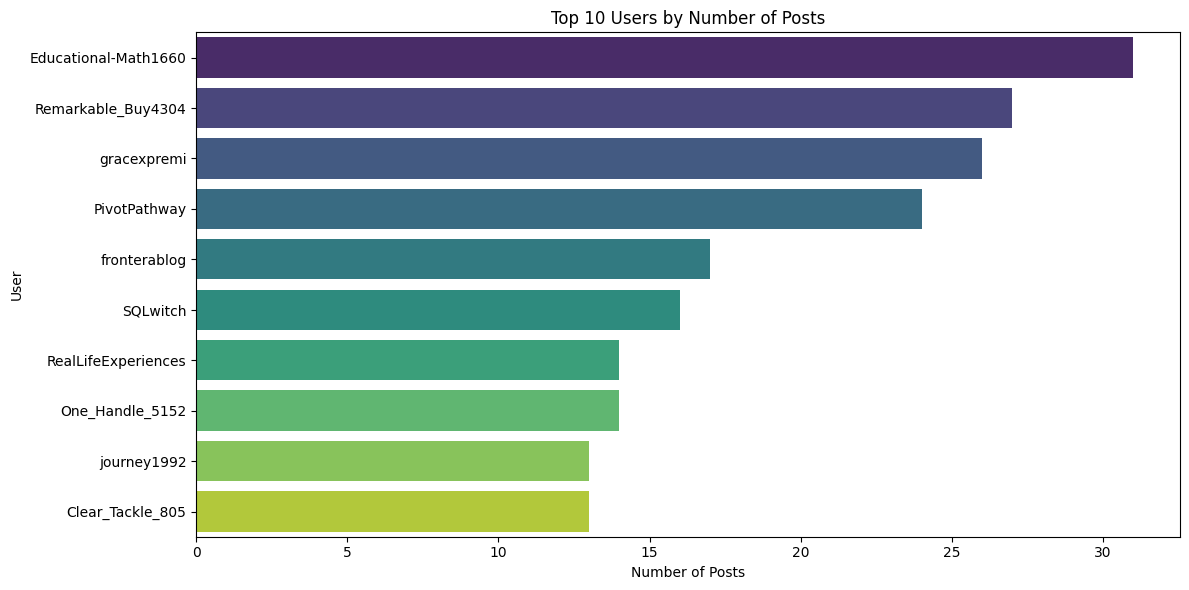

C:\Users\user\AppData\Local\Temp\ipykernel_15340\2197953381.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=reddit_df, x='year', palette='viridis')


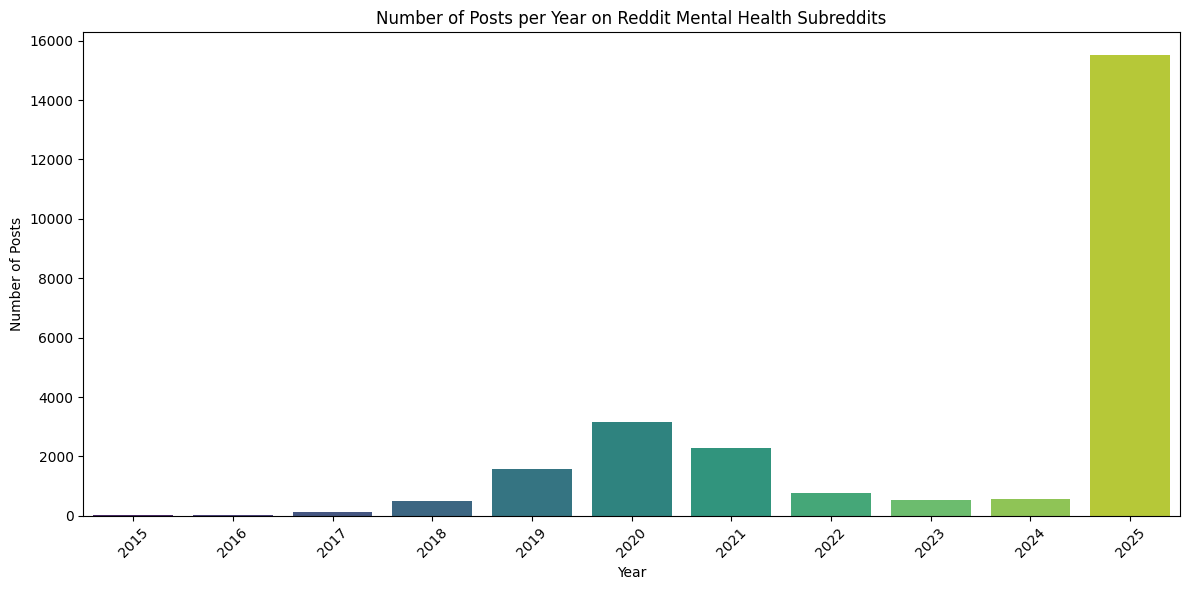

C:\Users\user\AppData\Local\Temp\ipykernel_15340\2197953381.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=reddit_df, y='subreddit', order=reddit_df['subreddit'].value_counts().index, palette='viridis')


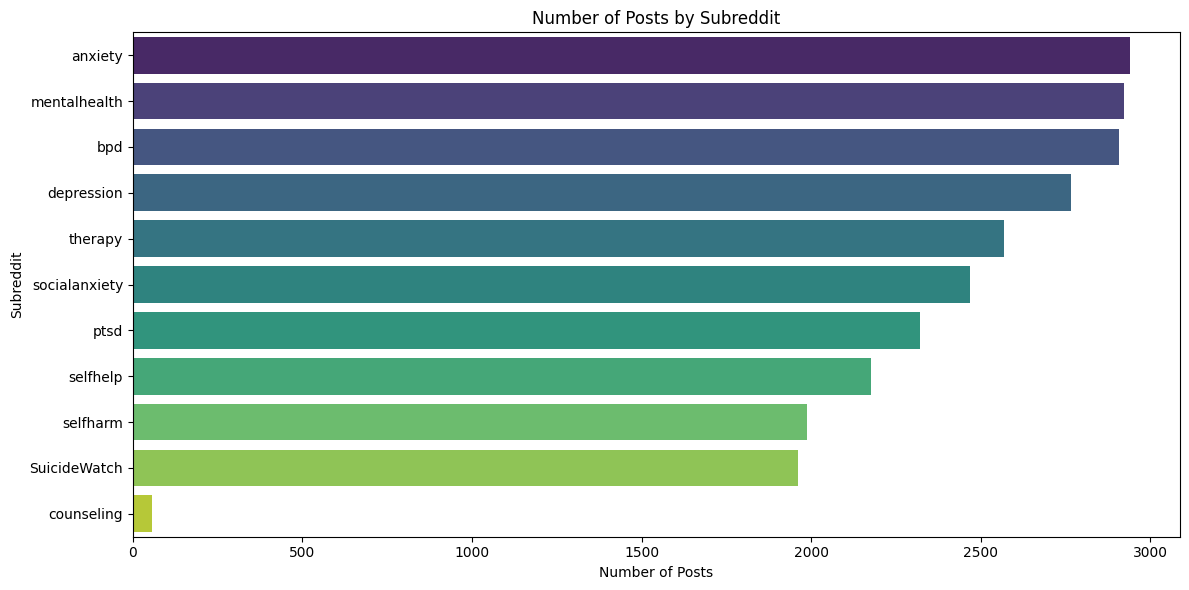

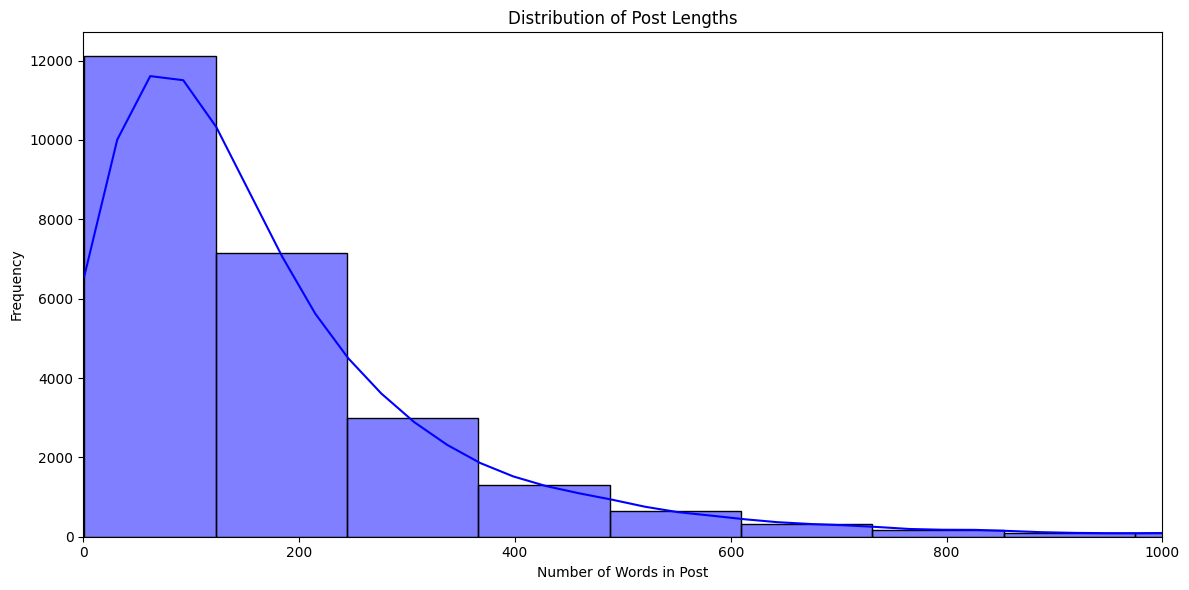

Top 20 N-grams (from 1 to 3 words):
N-gram: not, Count: 63961, Percentage: 0.53%
N-gram: go, Count: 43119, Percentage: 0.36%
N-gram: people, Count: 33834, Percentage: 0.28%
N-gram: make, Count: 31906, Percentage: 0.27%
N-gram: tng, Count: 28841, Percentage: 0.24%
N-gram: help, Count: 26162, Percentage: 0.22%
N-gram: s, Count: 25221, Percentage: 0.21%
N-gram: even, Count: 24492, Percentage: 0.20%
N-gram: say, Count: 24337, Percentage: 0.20%
N-gram: do, Count: 23931, Percentage: 0.20%
N-gram: try, Count: 23146, Percentage: 0.19%
N-gram: would, Count: 22411, Percentage: 0.19%
N-gram: one, Count: 22366, Percentage: 0.19%
N-gram: well, Count: 22262, Percentage: 0.19%
N-gram: you, Count: 21336, Percentage: 0.18%
N-gram: feel, Count: 21199, Percentage: 0.18%
N-gram: take, Count: 19538, Percentage: 0.16%
N-gram: need, Count: 19517, Percentage: 0.16%
N-gram: good, Count: 19466, Percentage: 0.16%
N-gram: do not, Count: 19220, Percentage: 0.16%

Last 20 N-grams (from 1 to 3 words):
N-gram: draw a

C:\Users\user\AppData\Local\Temp\ipykernel_15340\2197953381.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='N-gram', data=ngram_df, palette='viridis')


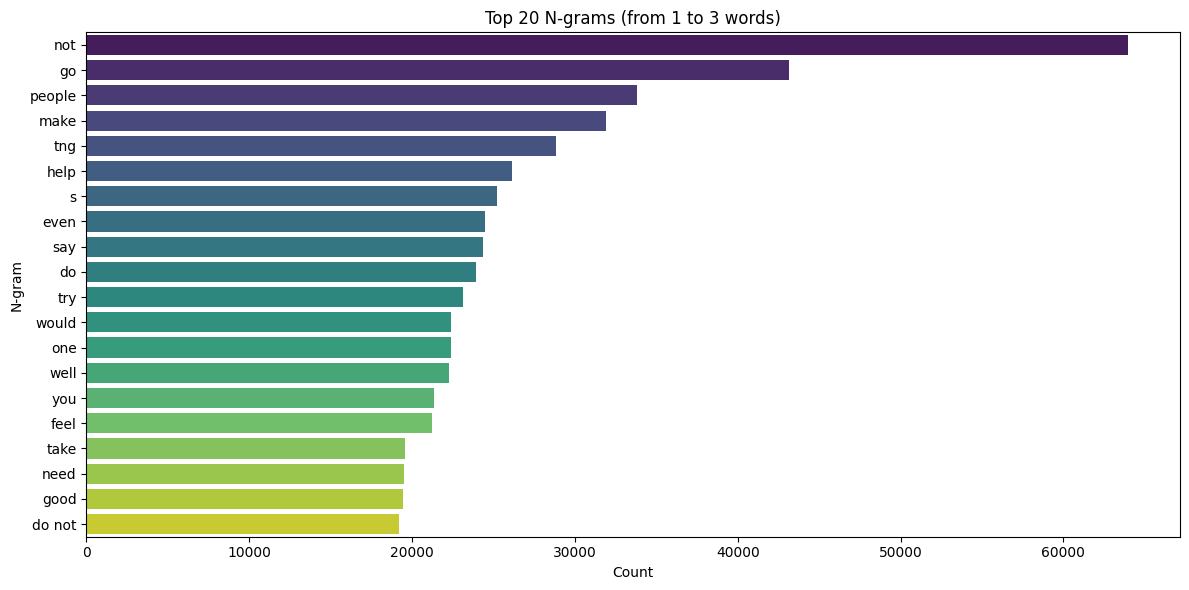

C:\Users\user\AppData\Local\Temp\ipykernel_15340\2197953381.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='N-gram', data=last_ngram_df, palette='viridis')


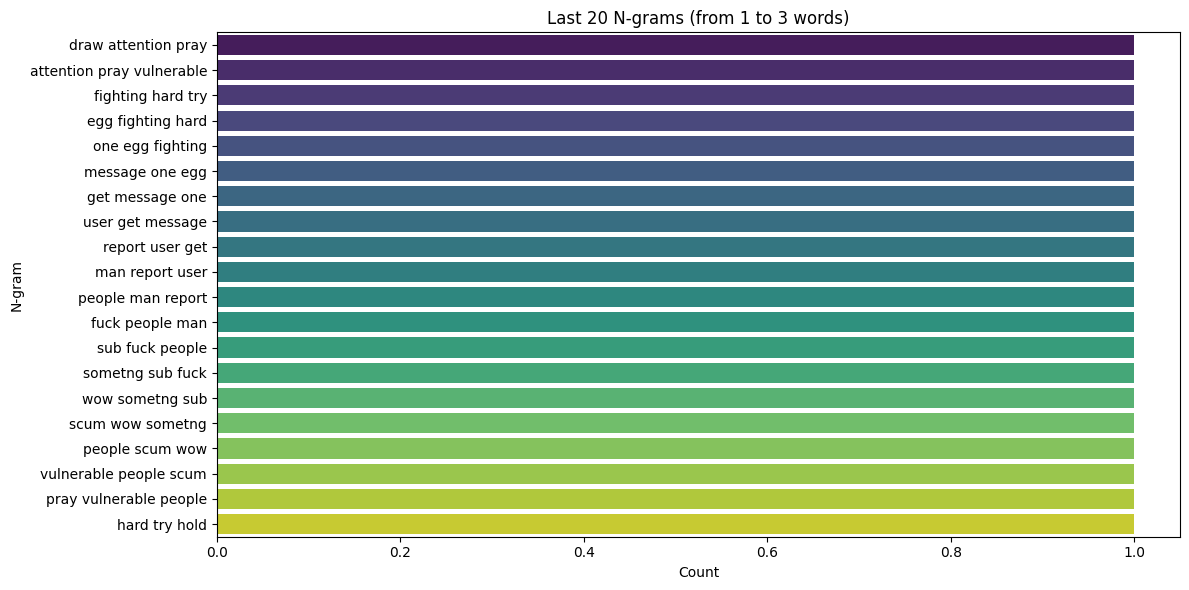

In [10]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


current_dir = os.getcwd()
reddit_df = pd.read_csv(os.path.join(current_dir, 'data', 'reddit_data', 'clean', 'cleaned_mental_all_text_2015up.csv')) 
lamme_reddit_df = " ".join(reddit_df['clean_title_selftext_topcomments_text'].tolist())





# check the total number of posts
total_posts = reddit_df.shape[0]
print(f"Total number of posts: {total_posts}")



# check the number of unique users
unique_users = reddit_df['author'].nunique()
print(f"Number of unique users: {unique_users}")


# plot the top 10 users who posted the most
top_users = reddit_df['author'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_users.values, y=top_users.index, palette='viridis')
plt.title('Top 10 Users by Number of Posts')
plt.xlabel('Number of Posts')
plt.ylabel('User')
plt.tight_layout()
plt.show()




# plot the number of posts per year
reddit_df['created_utc'] = pd.to_datetime(reddit_df['created_utc'], errors='coerce')
reddit_df['year'] = reddit_df['created_utc'].dt.year
plt.figure(figsize=(12, 6))
sns.countplot(data=reddit_df, x='year', palette='viridis')
plt.title('Number of Posts per Year on Reddit Mental Health Subreddits')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# plot the number of posts by subreddit
plt.figure(figsize=(12, 6))
sns.countplot(data=reddit_df, y='subreddit', order=reddit_df['subreddit'].value_counts().index, palette='viridis')
plt.title('Number of Posts by Subreddit')
plt.xlabel('Number of Posts')
plt.ylabel('Subreddit')
plt.tight_layout()
plt.show()


#plot the length of posts distribution 
reddit_df['post_length'] = (reddit_df['title'] + reddit_df['selftext']).apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12, 6))
sns.histplot(reddit_df['post_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Post Lengths')
plt.xlabel('Number of Words in Post')
plt.ylabel('Frequency')
plt.xlim(0, 1000)  # Limit x-axis to 500 words
plt.tight_layout()
plt.show()




# plot the top 10 frequence of tokens from the combination of unigrams, bigrams, and trigrams
from collections import Counter
import nltk
from nltk import ngrams
# nltk.download('punkt')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns


def plot_top_ngrams(text, top_n = 10,last_top_n = 10, ngram_range= (1, 3)):
    tokens = word_tokenize(text.lower())
    ngram_counts = Counter()

    for n in range(ngram_range[0], ngram_range[1] + 1):
        ngrams_list = ngrams(tokens, n)
        ngram_counts.update(ngrams_list)

    # Get the most common n-grams
    most_common_ngrams = ngram_counts.most_common(top_n)
    last_most_common_ngrams = ngram_counts.most_common()[-last_top_n:]

    # also show the percentage of each top_n from the total count
    total_count = sum(ngram_counts.values())
    most_common_ngrams = [(ngram, count, count / total_count * 100) for ngram, count in most_common_ngrams]
    last_most_common_ngrams = [(ngram, count, count / total_count * 100) for ngram, count in last_most_common_ngrams]

    print(f"Top {top_n} N-grams (from {ngram_range[0]} to {ngram_range[1]} words):")
    for ngram, count, percentage in most_common_ngrams:
        print(f"N-gram: {' '.join(ngram)}, Count: {count}, Percentage: {percentage:.2f}%")

    print(f"\nLast {last_top_n} N-grams (from {ngram_range[0]} to {ngram_range[1]} words):")
    for ngram, count, percentage in last_most_common_ngrams:
        print(f"N-gram: {' '.join(ngram)}, Count: {count}, Percentage: {percentage:.2f}%")

    
    #plot the top_n and last_top_n ngrams seperately
    ngram_df = pd.DataFrame(most_common_ngrams, columns=['N-gram', 'Count', 'Percentage'])
    ngram_df['N-gram'] = ngram_df['N-gram'].apply(lambda x: ' '.join(x))
    ngram_df = ngram_df.sort_values(by='Count', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(f'Top {top_n} N-grams (from {ngram_range[0]} to {ngram_range[1]} words)')
    plt.xlabel('Count')
    plt.ylabel('N-gram')
    plt.tight_layout()
    plt.show()

    # Prepare data for plotting last ngrams
    last_ngram_df = pd.DataFrame(last_most_common_ngrams, columns=['N-gram', 'Count', 'Percentage'])
    last_ngram_df['N-gram'] = last_ngram_df['N-gram'].apply(lambda x: ' '.join(x))
    last_ngram_df = last_ngram_df.sort_values(by='Count', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y='N-gram', data=last_ngram_df, palette='viridis')
    plt.title(f'Last {last_top_n} N-grams (from {ngram_range[0]} to {ngram_range[1]} words)')
    plt.xlabel('Count')
    plt.ylabel('N-gram')
    plt.tight_layout()
    plt.show()


    
plot_top_ngrams(lamme_reddit_df, top_n=20,last_top_n=20, ngram_range=(1, 3))


Beyondblue Data

Total number of posts in Beyond Blue: 4332
Number of unique users in Beyond Blue: 3457


C:\Users\user\AppData\Local\Temp\ipykernel_21816\2341376026.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users_beyondblue.values, y=top_users_beyondblue.index, palette='viridis')


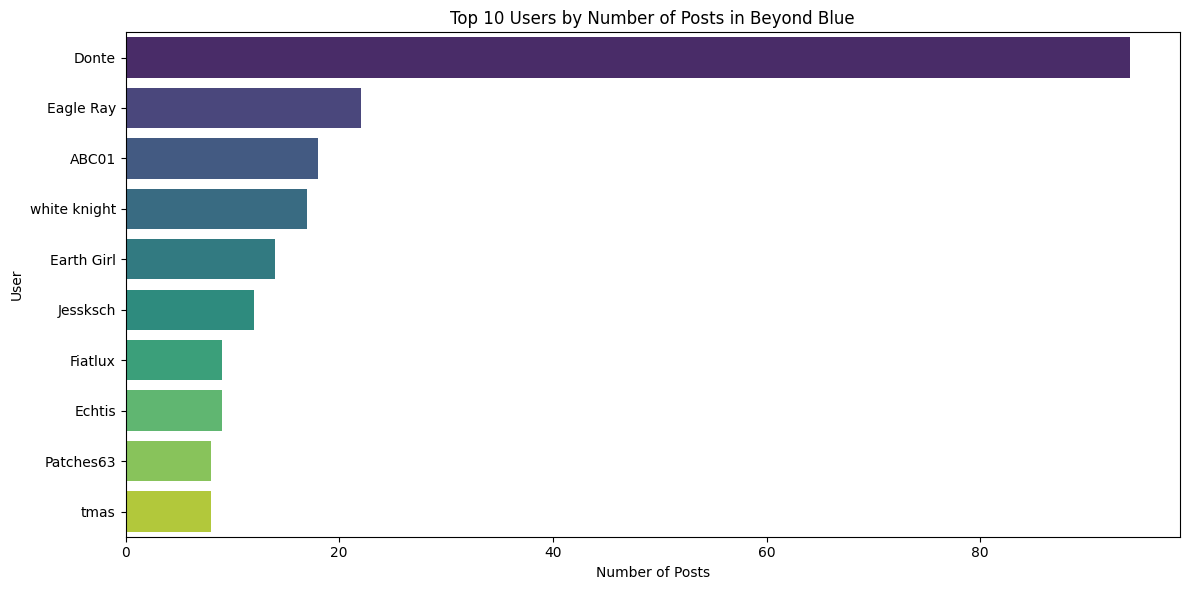

C:\Users\user\AppData\Local\Temp\ipykernel_21816\2341376026.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=beyondblue_df, x='year', palette='viridis')


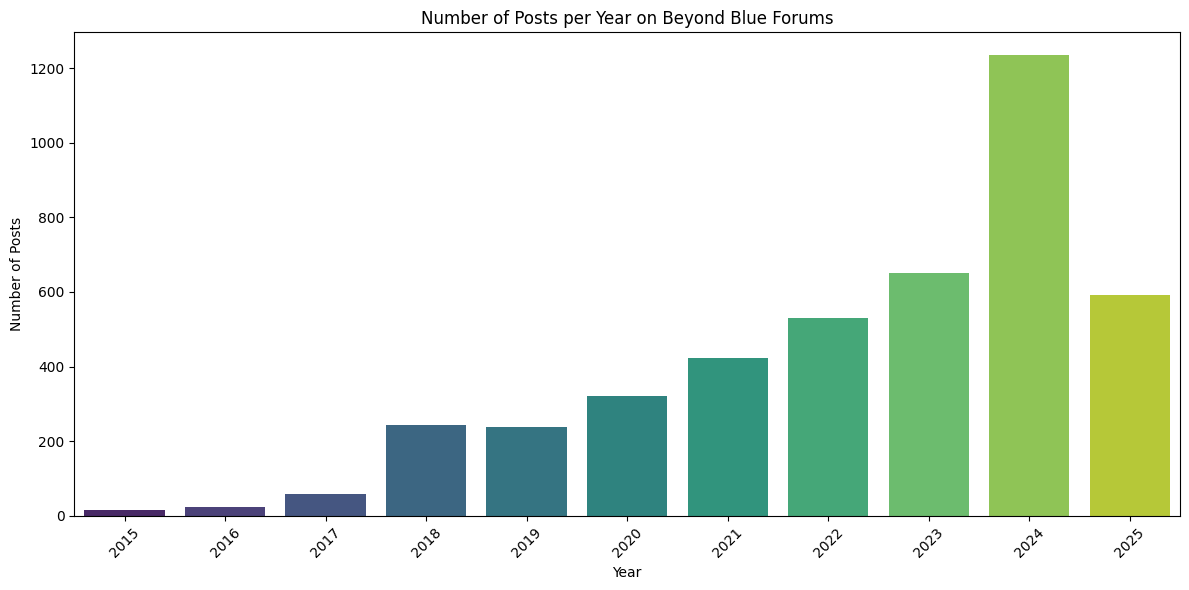

C:\Users\user\AppData\Local\Temp\ipykernel_21816\2341376026.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=beyondblue_df, y='Post Category', order=beyondblue_df['Post Category'].value_counts().index, palette='viridis')


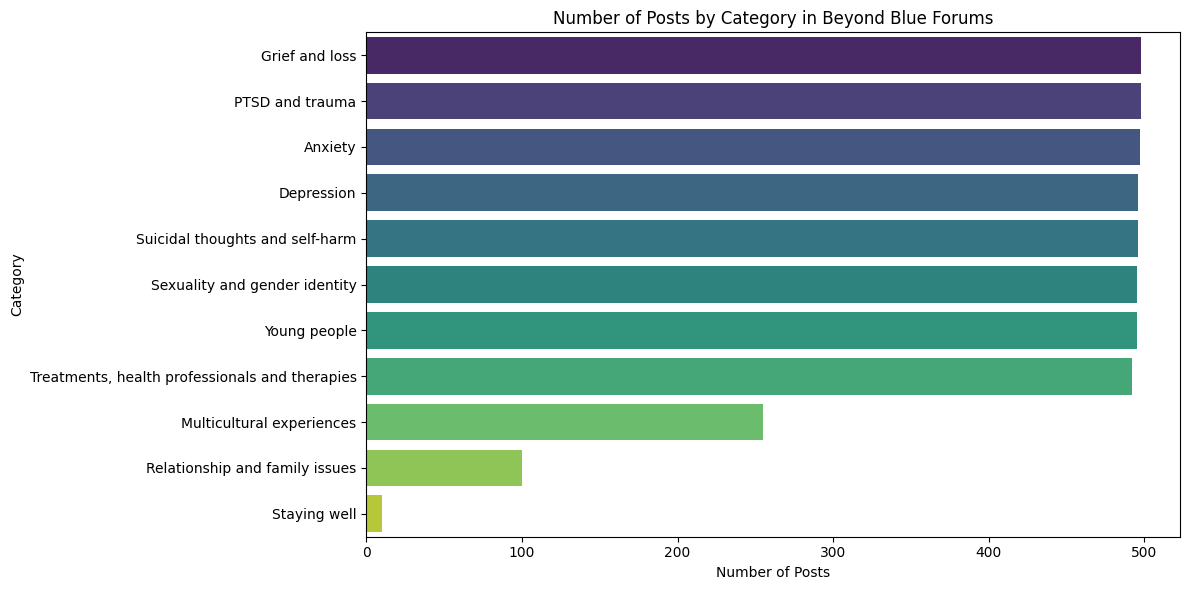

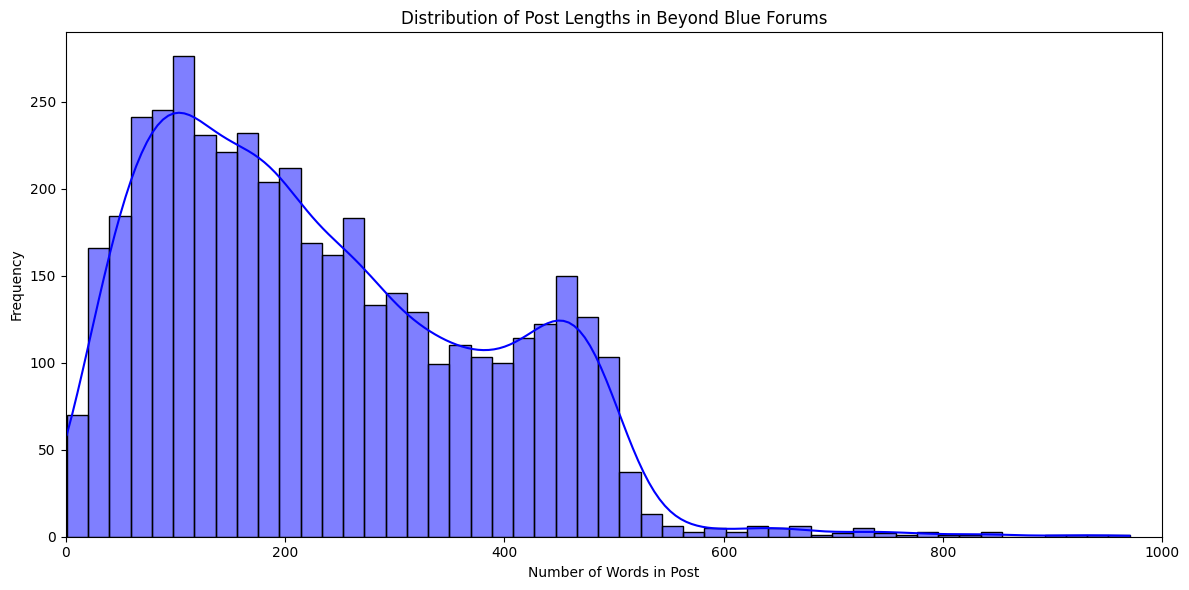

Top 20 N-grams (from 1 to 2 words):
N-gram: not, Count: 28192, Percentage: 0.87%
N-gram: go, Count: 18249, Percentage: 0.56%
N-gram: make, Count: 11526, Percentage: 0.35%
N-gram: would, Count: 11116, Percentage: 0.34%
N-gram: friend, Count: 10282, Percentage: 0.32%
N-gram: help, Count: 10150, Percentage: 0.31%
N-gram: feel, Count: 10144, Percentage: 0.31%
N-gram: work, Count: 10134, Percentage: 0.31%
N-gram: tng, Count: 9992, Percentage: 0.31%
N-gram: do, Count: 9887, Percentage: 0.30%
N-gram: say, Count: 9840, Percentage: 0.30%
N-gram: people, Count: 9816, Percentage: 0.30%
N-gram: one, Count: 9412, Percentage: 0.29%
N-gram: try, Count: 9190, Percentage: 0.28%
N-gram: day, Count: 9084, Percentage: 0.28%
N-gram: even, Count: 9051, Percentage: 0.28%
N-gram: can, Count: 8813, Percentage: 0.27%
N-gram: can not, Count: 8799, Percentage: 0.27%
N-gram: see, Count: 8287, Percentage: 0.25%
N-gram: tell, Count: 8210, Percentage: 0.25%

Last 20 N-grams (from 1 to 2 words):
N-gram: weight ruin, C

C:\Users\user\AppData\Local\Temp\ipykernel_21816\2341376026.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='N-gram', data=ngram_df, palette='viridis')


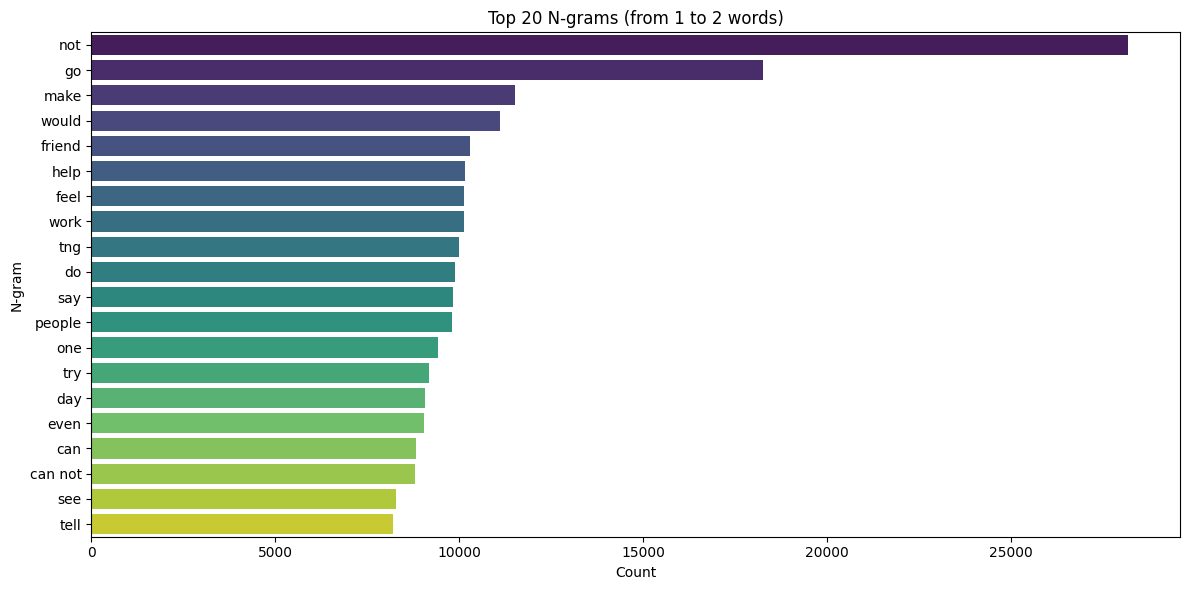

C:\Users\user\AppData\Local\Temp\ipykernel_21816\2341376026.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='N-gram', data=last_ngram_df, palette='viridis')


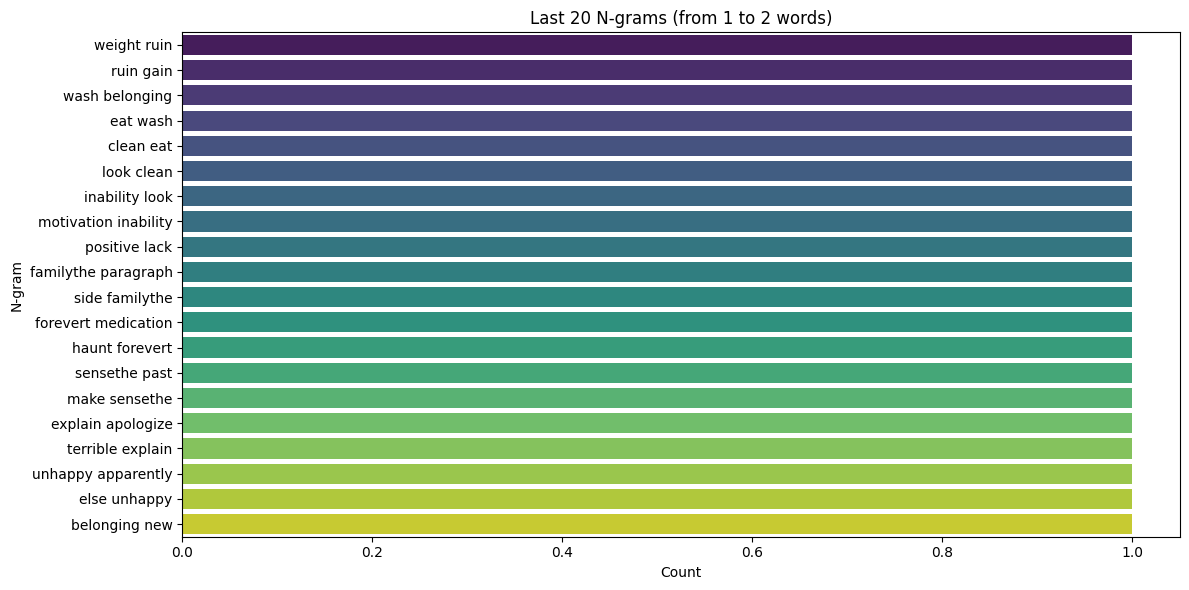

In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

current_dir = os.getcwd()
beyondblue_df = pd.read_csv(os.path.join(current_dir, 'data', 'beyondblue_data', 'clean', 'cleaned_beyondblue_all_text_2015up.csv'))
lamme_beyondblue_df = " ".join(beyondblue_df['clean_title_content_comments'].tolist())




# check the total number of posts
total_posts_beyondblue = beyondblue_df.shape[0]
print(f"Total number of posts in Beyond Blue: {total_posts_beyondblue}")


# check the number of unique users
unique_users_beyondblue = beyondblue_df['Post Author'].nunique()
print(f"Number of unique users in Beyond Blue: {unique_users_beyondblue}")





# plot the top 10 users who posted the most
top_users_beyondblue = beyondblue_df['Post Author'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_users_beyondblue.values, y=top_users_beyondblue.index, palette='viridis')
plt.title('Top 10 Users by Number of Posts in Beyond Blue')
plt.xlabel('Number of Posts')
plt.ylabel('User')
plt.tight_layout()
plt.show()


# plot the number of posts per year
beyondblue_df['Post Date'] = pd.to_datetime(beyondblue_df['Post Date'], errors='coerce')
beyondblue_df['year'] = beyondblue_df['Post Date'].dt.year
plt.figure(figsize=(12, 6))
sns.countplot(data=beyondblue_df, x='year', palette='viridis')
plt.title('Number of Posts per Year on Beyond Blue Forums')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# plot the number of posts by subreddit
plt.figure(figsize=(12, 6))
sns.countplot(data=beyondblue_df, y='Post Category', order=beyondblue_df['Post Category'].value_counts().index, palette='viridis')
plt.title('Number of Posts by Category in Beyond Blue Forums')
plt.xlabel('Number of Posts')
plt.ylabel('Category')
plt.tight_layout()
plt.show()



#plot the length of posts distribution 
beyondblue_df['post_length'] = (beyondblue_df['Post Title'] + beyondblue_df['Post Content']).apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12, 6))
sns.histplot(beyondblue_df['post_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Post Lengths in Beyond Blue Forums')
plt.xlabel('Number of Words in Post')
plt.ylabel('Frequency')
plt.xlim(0, 1000)  # Limit x-axis to 500 words
plt.tight_layout()
plt.show()






# plot the top 10 and last top 10  frequence of tokens from the combination of unigrams, bigrams, and trigrams
from collections import Counter
import nltk
from nltk import ngrams
# nltk.download('punkt')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_ngrams(text, top_n = 10,last_top_n = 10, ngram_range= (1, 3)):
    tokens = word_tokenize(text.lower())
    ngram_counts = Counter()

    for n in range(ngram_range[0], ngram_range[1] + 1):
        ngrams_list = ngrams(tokens, n)
        ngram_counts.update(ngrams_list)

    # Get the most common n-grams
    most_common_ngrams = ngram_counts.most_common(top_n)
    last_most_common_ngrams = ngram_counts.most_common()[-last_top_n:]

    # also show the percentage of each top_n from the total count
    total_count = sum(ngram_counts.values())
    most_common_ngrams = [(ngram, count, count / total_count * 100) for ngram, count in most_common_ngrams]
    last_most_common_ngrams = [(ngram, count, count / total_count * 100) for ngram, count in last_most_common_ngrams]

    print(f"Top {top_n} N-grams (from {ngram_range[0]} to {ngram_range[1]} words):")
    for ngram, count, percentage in most_common_ngrams:
        print(f"N-gram: {' '.join(ngram)}, Count: {count}, Percentage: {percentage:.2f}%")

    print(f"\nLast {last_top_n} N-grams (from {ngram_range[0]} to {ngram_range[1]} words):")
    for ngram, count, percentage in last_most_common_ngrams:
        print(f"N-gram: {' '.join(ngram)}, Count: {count}, Percentage: {percentage:.2f}%")

    
    #plot the top_n and last_top_n ngrams seperately
    ngram_df = pd.DataFrame(most_common_ngrams, columns=['N-gram', 'Count', 'Percentage'])
    ngram_df['N-gram'] = ngram_df['N-gram'].apply(lambda x: ' '.join(x))
    ngram_df = ngram_df.sort_values(by='Count', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(f'Top {top_n} N-grams (from {ngram_range[0]} to {ngram_range[1]} words)')
    plt.xlabel('Count')
    plt.ylabel('N-gram')
    plt.tight_layout()
    plt.show()

    # Prepare data for plotting last ngrams
    last_ngram_df = pd.DataFrame(last_most_common_ngrams, columns=['N-gram', 'Count', 'Percentage'])
    last_ngram_df['N-gram'] = last_ngram_df['N-gram'].apply(lambda x: ' '.join(x))
    last_ngram_df = last_ngram_df.sort_values(by='Count', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y='N-gram', data=last_ngram_df, palette='viridis')
    plt.title(f'Last {last_top_n} N-grams (from {ngram_range[0]} to {ngram_range[1]} words)')
    plt.xlabel('Count')
    plt.ylabel('N-gram')
    plt.tight_layout()
    plt.show()


    
plot_top_ngrams(lamme_beyondblue_df, top_n=20,last_top_n=20, ngram_range=(1, 2))






Weather Data

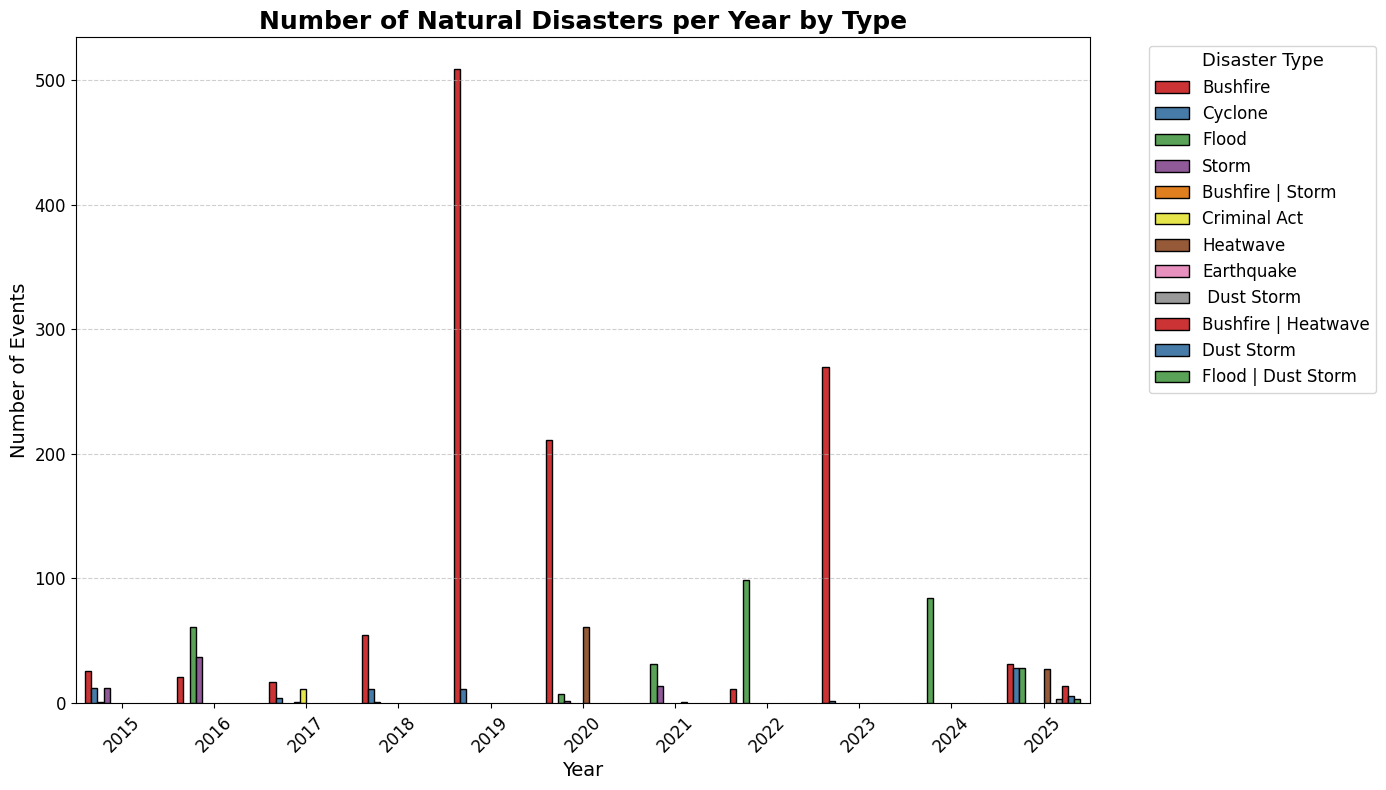

In [8]:

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

current_dir = os.getcwd()
weather_df = pd.read_csv(os.path.join(current_dir, 'data', 'AUS_weather', 'AUS_bigcity_weather_data_cleaned_2015up.csv'))


# Convert 'Date' column to datetime and extract year
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year

# Filter for rows with non-empty extreme weather events
extreme_events = weather_df[weather_df['Extreme_weather'].notna()]

# Group by year and extreme weather type
events_by_type = extreme_events.groupby(['Year', 'Extreme_weather']).size().reset_index(name='Count')

# Set a bright color palette
palette = sns.color_palette("Set1", n_colors=events_by_type['Extreme_weather'].nunique())

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=events_by_type,
    x='Year',
    y='Count',
    hue='Extreme_weather',
    palette=palette,
    edgecolor='black'  # Add black edges to bars
)

# Aesthetic improvements
plt.title('Number of Natural Disasters per Year by Type', fontsize=18, weight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Events', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Disaster Type', fontsize=12, title_fontsize=13, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()